## Smallest nonzero persistent eigenvalue of a filtration

In [16]:
import tadasets
from persistent_laplacians.eigenvalues import compute_eigenvalues 
sphere = tadasets.dsphere(n=300, d=2, r=2, noise=0.1, seed=42)

In [30]:
result = compute_eigenvalues(sphere, num_indices=10, use_scipy=True, use_stepwise_schur=True)

## Plot nonpersistent eigenvalues (dim 1)

[0.023415364518968827, 0.03497230622978692, 0.05844692873692779, 0.059931925877652996, 0.07642828570376324, 0.14087823046828266, 0.4009844032730731, 0.5209755071283806, 0.7029912586533094]


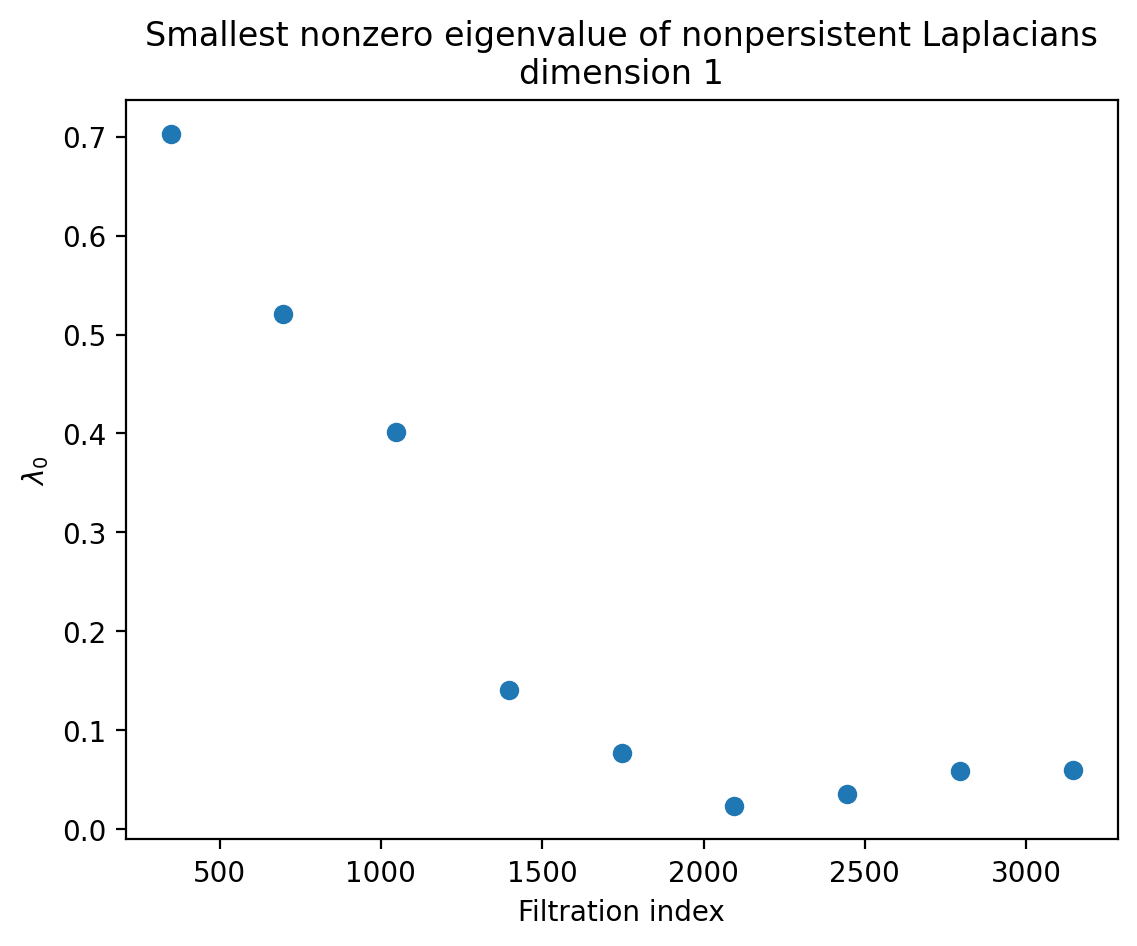

In [31]:
import matplotlib.pyplot as plt
nonpersistent = {k[0]: v[0] for (k, v) in result[2].items() if k[0] == k[1] and len(v) >= 1}
plt.figure(dpi=200)
plt.scatter(nonpersistent.keys(), nonpersistent.values())
plt.title(r"Smallest nonzero eigenvalue of nonpersistent Laplacians" + "\n" + "dimension 1")
plt.xlabel("Filtration index")
plt.ylabel(r"$\lambda_0$")

eigenvalues = sorted(nonpersistent.values())

print(eigenvalues[0:10])

## Persistent smallest nonzero eigenvalues

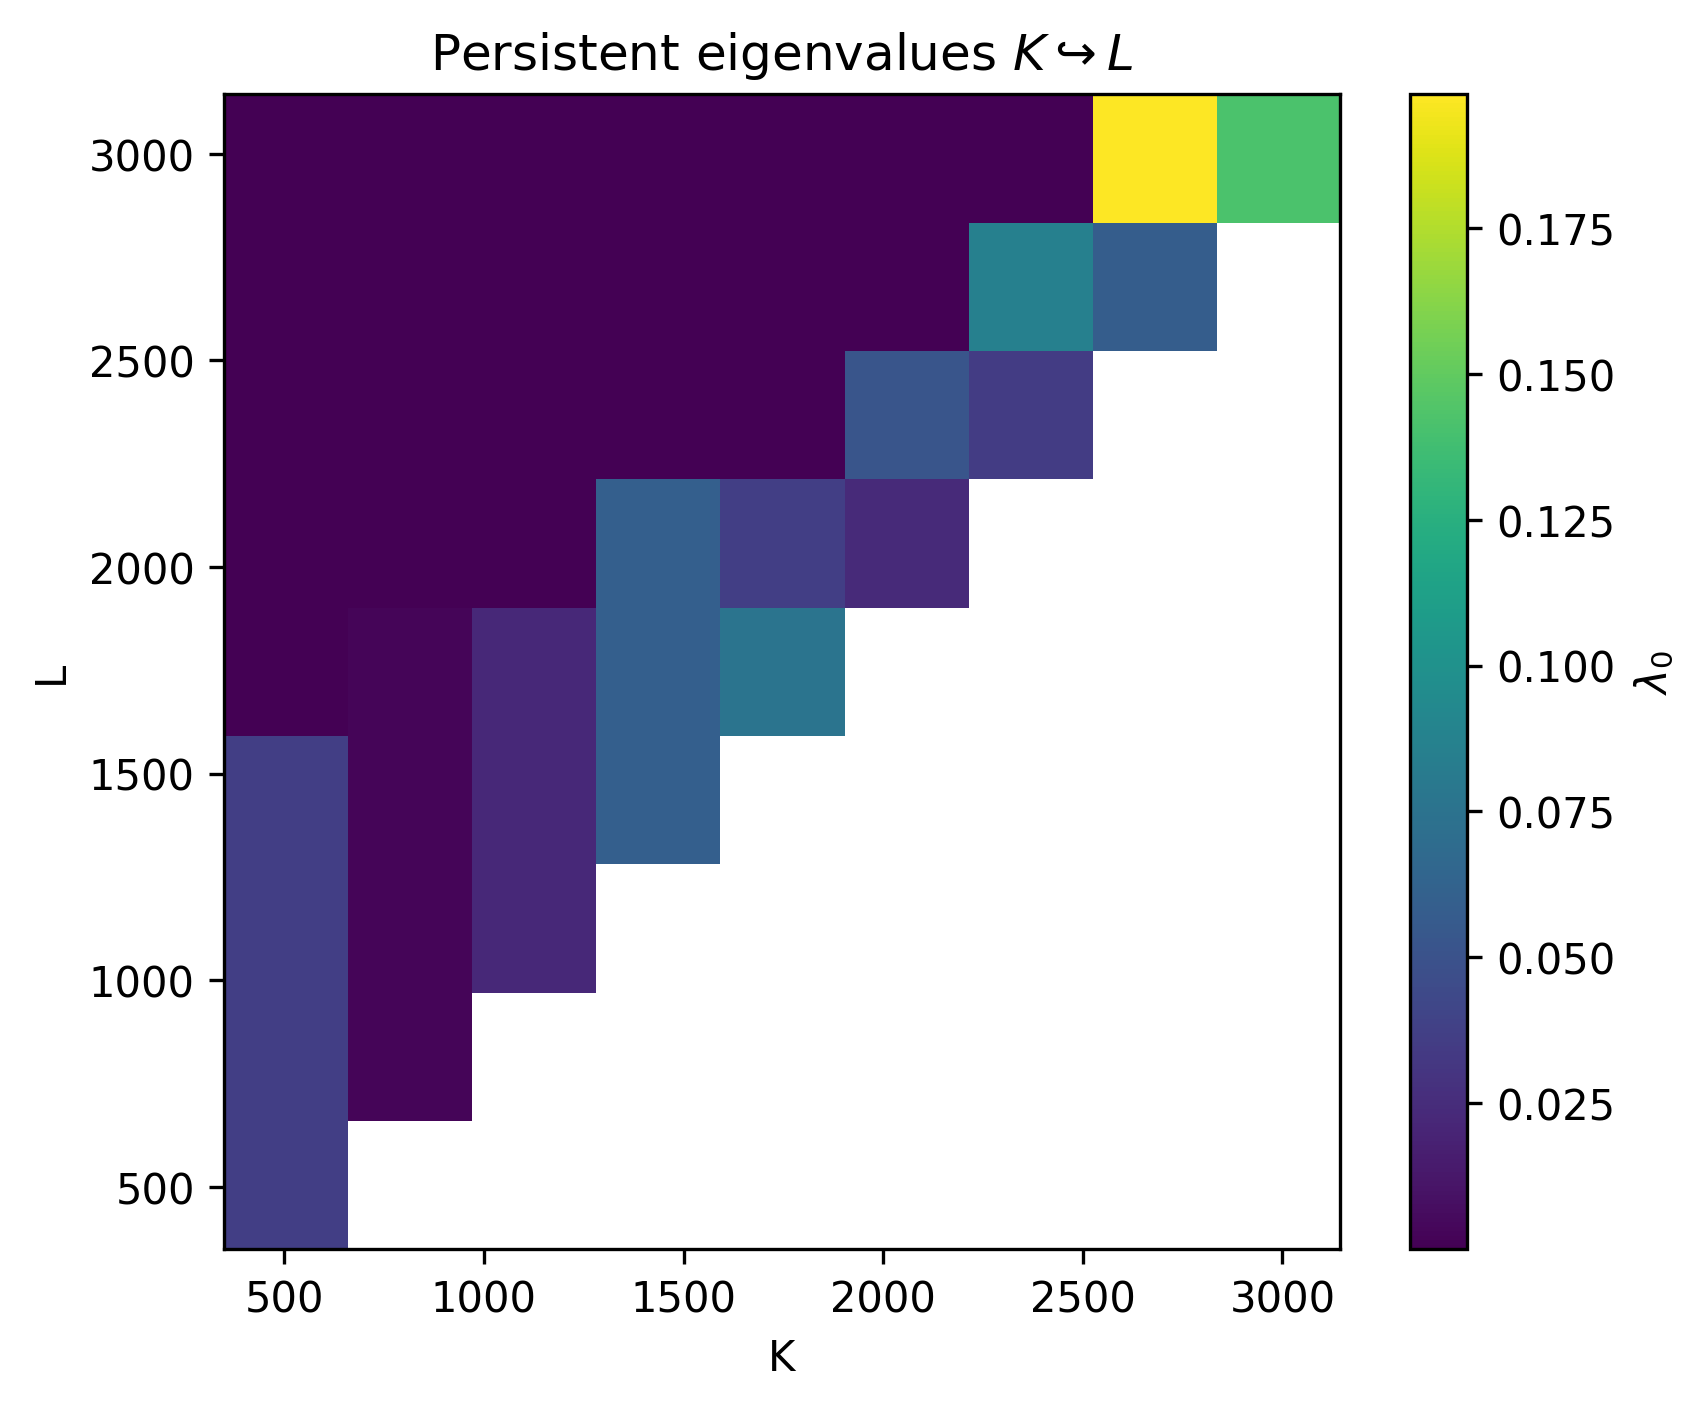

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Raw data
pts = {k: v for (k, v) in result[1].items() if len(v) >= 1}

# 1) Build sorted unique axes
xs = sorted({x for x, y in pts})
ys = sorted({y for x, y in pts})

# 2) Create matrix of NaNs
heat = np.full((len(ys), len(xs)), np.nan)

# 3) Fill matrix: row = y-index, col = x-index
x_i = {x:i for i,x in enumerate(xs)}
y_i = {y:i for i,y in enumerate(ys)}
for (x,y), v in pts.items():
    heat[y_i[y], x_i[x]] = v[0]

# 4) Plot as heatmap (no interpolation)
plt.figure(figsize=(6,5), dpi=300)
plt.imshow(
    heat,
    origin='lower',
    extent=(min(xs), max(xs), min(ys), max(ys)),
    aspect='auto'
)
plt.colorbar(label=r'$\lambda_0$')
plt.xlabel('K')
plt.ylabel('L')
plt.title(r'Persistent eigenvalues $K \hookrightarrow L$')
plt.show()

### When is the up persistent value getting used?
Whenever the diagonal eigenvalue (nonpersistent) is not the same as one of the column values, the UP persistent laplacian gets used.

In [33]:
# Find all y for which (y,y) exists
pts = result[2]
diagonal = {y: pts[(y,y)] for (y1,y2) in pts if y1==y2}
# Compare
for (x,y), v in pts.items():
    if x!=y and (x,x) in pts and (abs(v[0] - pts[(x,x)][0]) > 1e-6):
        print(f"At y={y}, x={x}: {v} ≠ diagonal {pts[(x,x)]}")